# CelebA Dataset

1. download dataset
2. visualize dataset
3. develop pytorch DataModule API for "sampling" a dataset that introduces interventions
4. sample a batch and visualize

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import os
import re
from copy import copy
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from albumentations import (
    CoarseDropout,
    Compose,
    ElasticTransform,
    GridDistortion,
    HorizontalFlip,
    OneOf,
    RandomBrightnessContrast,
    HueSaturationValue,
    GaussianBlur,
    Perspective,
    RandomCrop,
)
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CelebA

In [3]:
def viz_image(img):
    # Step 4: Plot the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)  # Convert (C, H, W) to (H, W, C) for visualization
    plt.axis("off")
    plt.title("Sample CelebA Image")
    plt.show()

In [4]:
# Root directory for the dataset
data_root = Path("/Users/adam2392/pytorch_data/")
# Spatial size of training images, images are resized to this size.
image_size = 128

celeba_data = CelebA(
    data_root,
    download=True,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    ),
)

Files already downloaded and verified


In [5]:
print(celeba_data)
attr_names = celeba_data.attr_names
gender_idx = attr_names.index("Male")
age_idx = attr_names.index("Young")

blackhair_idx = attr_names.index("Black_Hair")
blondhair_idx = attr_names.index("Blond_Hair")
brownhair_idx = attr_names.index("Brown_Hair")
grayhair_idx = attr_names.index("Gray_Hair")
print(celeba_data.attr[:, gender_idx].shape)

Dataset CelebA
    Number of datapoints: 162770
    Root location: /Users/adam2392/pytorch_data
    Target type: ['attr']
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
torch.Size([162770])


In [6]:
attr_names_arr = np.array(attr_names, dtype=np.str_)
# Use numpy's vectorized string operations to check for "Hair"
# hair_mask = np.char.find(attr_names_arr, "Hair") >= 0  # Returns True for matching elements

# Use np.argwhere to get the indices of matching elements
hair_cols = np.array([blackhair_idx, blondhair_idx, brownhair_idx, grayhair_idx])
print(attr_names_arr[hair_cols])
print(hair_cols)

print(celeba_data.attr[:, hair_cols].shape)
print(torch.sum(celeba_data.attr[:, hair_cols], axis=1))

['Black_Hair' 'Blond_Hair' 'Brown_Hair' 'Gray_Hair']
[ 8  9 11 17]
torch.Size([162770, 4])
tensor([1, 1, 0,  ..., 1, 1, 0])


In [53]:
img = celeba_data[2]
print(len(img))

2


In [49]:
viz_image(celeba_data[2])

AttributeError: 'tuple' object has no attribute 'permute'

<Figure size 500x500 with 0 Axes>

# Sample a multi-distributional dataset

Here, we will work with a dataset that is sampled according to the graph

Gender <--> Age -> Hair-Color

- U_{age,gender} is sampled uniformly between [0, 1]
- Male and Old are then sampled according to Binomial(n, p), where n is the number of images we have, and p is U_{age, gender}
- 

In [7]:
male_attrs = celeba_data.attr[:, gender_idx]
young_attrs = celeba_data.attr[:, age_idx]
hair_attrs = celeba_data.attr[:, hair_cols]

# 0: black
# 1: blond
# 2: brown
# 3: gray
hair_attrs = np.argmax(hair_attrs, axis=1)

Text(0.5, 1.0, 'Distribution of Black, Blond, Brown and Gray Hair')

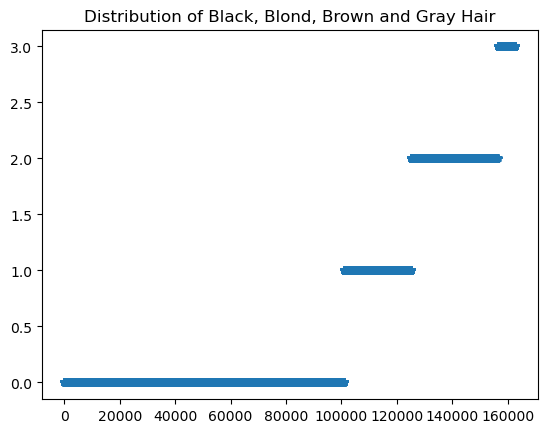

In [65]:
plt.plot(sorted(hair_attrs.squeeze()), "*")
plt.title("Distribution of Black, Blond, Brown and Gray Hair")

Text(0.5, 1.0, 'Distribution of Old and Young')

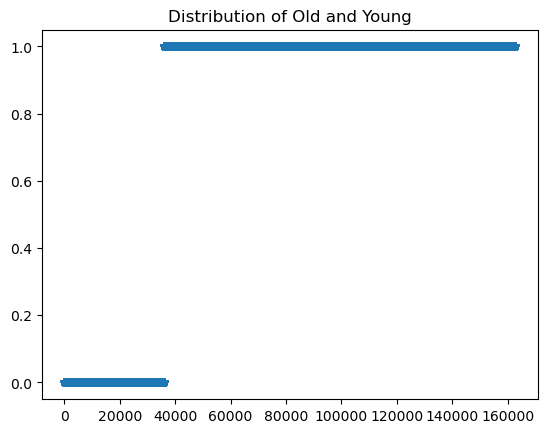

In [67]:
plt.plot(sorted(young_attrs.squeeze()), "*")
plt.title("Distribution of Old and Young")

Text(0.5, 1.0, 'Distribution of Female and Male')

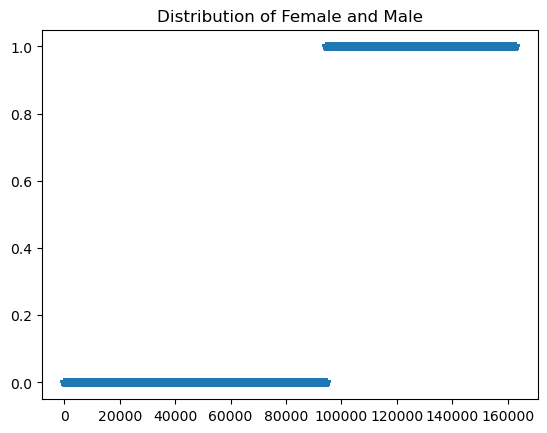

In [83]:
plt.plot(sorted(male_attrs.squeeze()), "*")
plt.title("Distribution of Female and Male")

# Multi-distributional SCMs

Observational and hair-color changes.

In [26]:
def exponential_weights(i_range, alpha=1.0):
    weights = [np.exp(alpha * i) for i in i_range]
    # Normalize weights so they sum to 1
    total = sum(weights)
    normalized_weights = [w / total for w in weights]
    return normalized_weights


def print_transforms(transforms, indent=0):
    for i, transform in enumerate(transforms):
        if isinstance(transform, OneOf):
            print("  " * indent + f"Transformation {i+1}: OneOf")
            print_transforms(transform.transforms, indent + 1)
        else:
            print(
                "  " * indent + f"Transformation {i+1}: {transform.__class__.__name__}"
            )


# Albumentations transformations pipeline
def get_random_transforms():
    return Compose(
        [
            OneOf(
                [
                    RandomCrop(
                        width=image_size - 6,
                        height=image_size - 6,
                        always_apply=False,
                        p=0.3,
                    ),
                    # GridDistortion(num_steps=10, p=0.3),
                    # ElasticTransform(alpha=1, sigma=25, alpha_affine=None, p=0.3),
                ],
                p=0.5,
            ),
            # OneOf(
            #     [
            #         GaussianBlur(blur_limit=(3, 3), p=0.3),
            #         Perspective(scale=(0.05, 0.1), p=0.3),
            #     ],
            #     p=0.5,
            # ),
            # RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
            # HueSaturationValue(
            #     # hue_shift_limit=10,
            #     # sat_shift_limit=5,
            #     # val_shift_limit=20,
            #     p=0.4,
            # ),
            CoarseDropout(
                max_holes=16,
                max_height=3,
                max_width=3,
                min_holes=1,
                min_height=1,
                min_width=1,
                p=0.3,
            ),
            HorizontalFlip(p=0.5),
            ToTensorV2(),
        ]
    )

In [9]:
def obs_sample_img_indices(
    male_attrs, young_attrs, hair_attrs, n_samples=1000, seed=None
):
    """Set up the observational SCM."""
    rng = np.random.default_rng(seed)

    sample_idx = np.arange(len(male_attrs))
    image_attrs = np.concatenate(
        (
            sample_idx.reshape(-1, 1),
            male_attrs.reshape(-1, 1),
            young_attrs.reshape(-1, 1),
            hair_attrs.reshape(-1, 1),
        ),
        axis=1,
    )

    # Precompute hair categories
    # hair_categories = np.unique(hair_attrs).astype(int).tolist()
    hair_categories = ["Black", "Blond", "Brown", "Gray"]

    # List to store sampled indices
    sampled_indices = []
    sampled_attrs = []
    for idx in range(n_samples):
        # shuffle image attributes
        rng.shuffle(sample_idx)
        image_attrs = image_attrs[sample_idx]

        # now, sample U_gh and use this to initialize the sampling process
        U_genderhair = rng.uniform()

        # now sample male based on bernoulli
        p_male = U_genderhair
        gender_str = "Male" if rng.uniform() < p_male else "Female"
        gender_map = {"Male": 1, "Female": 0}
        gender = gender_map[gender_str]

        p_old = U_genderhair
        age_str = "Old" if rng.uniform() < p_old else "Young"
        age_map = {"Young": 1, "Old": 0}
        age = age_map[age_str]

        hair_range = np.arange(4)
        if age == "Old":
            hair_range = hair_range[::-1]
        p_hairs = exponential_weights(hair_range, alpha=1.0)
        hair_str = rng.choice(hair_categories, p=p_hairs)

        # 0: black
        # 1: blond
        # 2: brown
        # 3: gray
        hair_map = {"Black": 0, "Blond": 1, "Brown": 2, "Gray": 3}
        hair = hair_map[hair_str]

        # now sample an individual that is Male, Old and X-Hair color
        matching_indices = image_attrs[
            (image_attrs[:, 1] == gender)
            & (image_attrs[:, 2] == age)
            & (image_attrs[:, 3] == hair)
        ][
            :, 0
        ].tolist()  # Extract indices

        # Sample a single individual if there are matches
        if matching_indices:
            sampled_index = rng.choice(matching_indices)
            sampled_indices.append(sampled_index)
            sampled_attrs.append((sampled_index, gender_str, age_str, hair_str))
    return sampled_indices, sampled_attrs


def interventional_sample_img_indices(
    male_attrs, young_attrs, hair_attrs, idx=0, n_samples=1000, seed=None
):
    """Set up the observational SCM."""
    # Precompute hair categories
    if idx == 0:
        hair_categories = ["Gray", "Brown"]
    elif idx == 1:
        hair_categories = ["Black", "Blond"]

    rng = np.random.default_rng(seed)

    sample_idx = np.arange(len(male_attrs))
    image_attrs = np.concatenate(
        (
            sample_idx.reshape(-1, 1),
            male_attrs.reshape(-1, 1),
            young_attrs.reshape(-1, 1),
            hair_attrs.reshape(-1, 1),
        ),
        axis=1,
    )

    # List to store sampled indices
    sampled_indices = []
    sampled_attrs = []
    for idx in range(n_samples):
        # shuffle image attributes
        rng.shuffle(sample_idx)
        image_attrs = image_attrs[sample_idx]

        # now, sample U_gh and use this to initialize the sampling process
        U_genderhair = rng.uniform()

        # now sample male based on bernoulli
        p_male = U_genderhair
        gender_str = "Male" if rng.uniform() < p_male else "Female"
        gender_map = {"Male": 1, "Female": 0}
        gender = gender_map[gender_str]

        p_old = U_genderhair
        age_str = "Old" if rng.uniform() < p_old else "Young"
        age_map = {"Young": 1, "Old": 0}
        age = age_map[age_str]

        hair_range = np.arange(2)
        if age == "Old":
            hair_range = hair_range[::-1]
        p_hairs = exponential_weights(hair_range, alpha=1.0)
        hair_str = rng.choice(hair_categories, p=p_hairs)

        # 0: black
        # 1: blond
        # 2: brown
        # 3: gray
        hair_map = {"Black": 0, "Blond": 1, "Brown": 2, "Gray": 3}
        hair = hair_map[hair_str]

        # now sample an individual that is Male, Old and X-Hair color
        matching_indices = image_attrs[
            (image_attrs[:, 1] == gender)
            & (image_attrs[:, 2] == age)
            & (image_attrs[:, 3] == hair)
        ][
            :, 0
        ].tolist()  # Extract indices

        # Sample a single individual if there are matches
        if matching_indices:
            sampled_index = rng.choice(matching_indices)
            sampled_indices.append(sampled_index)
            sampled_attrs.append((sampled_index, gender_str, age_str, hair_str))
    return sampled_indices, sampled_attrs

In [ ]:
def celeba_scm(
    celeba_data,
    save_dir,
    scm_type="obs",
    interv_idx=0,
    n_samples=1000,
    seed=None,
    append=False,
):
    attr_names = copy(celeba_data.attr_names)
    gender_idx = attr_names.index("Male")
    age_idx = attr_names.index("Young")

    blackhair_idx = attr_names.index("Black_Hair")
    blondhair_idx = attr_names.index("Blond_Hair")
    brownhair_idx = attr_names.index("Brown_Hair")
    grayhair_idx = attr_names.index("Gray_Hair")

    # Use np.argwhere to get the indices of matching elements
    hair_cols = np.array([blackhair_idx, blondhair_idx, brownhair_idx, grayhair_idx])

    male_attrs = celeba_data.attr[:, gender_idx]
    young_attrs = celeba_data.attr[:, age_idx]
    hair_attrs = celeba_data.attr[:, hair_cols]

    # 0: black
    # 1: blond
    # 2: brown
    # 3: gray
    hair_attrs = np.argmax(hair_attrs, axis=1)

    if scm_type == "obs":
        sample_indices, sampled_attrs = obs_sample_img_indices(
            male_attrs, young_attrs, hair_attrs, n_samples=n_samples, seed=seed
        )
    else:
        sample_indices, sampled_attrs = interventional_sample_img_indices(
            male_attrs,
            young_attrs,
            hair_attrs,
            idx=interv_idx,
            n_samples=n_samples,
            seed=seed,
        )
    saved_attrs = []
    saved_causal_attrs = []

    if append:
        # Define the pattern to match the file names
        pattern = re.compile(r"sample_(\d+)\.jpg")
        max_idx = 0  # Start with a default value for empty directory
        for file_name in os.listdir(save_dir):
            match = pattern.match(file_name)
            if match:
                idx = int(match.group(1))  # Extract the number
                max_idx = max(max_idx, idx)  # Update the maximum
    else:
        max_idx = 0

    # now actually sample the images, apply transformation and save them to disc
    for idx, sample_idx in enumerate(sample_indices):
        image, meta_attrs = celeba_data[sample_idx]
        image = torch.permute(image, (1, 2, 0))

        # Apply transformations
        transform_pipeline = get_random_transforms()
        transformed = transform_pipeline(image=np.array(image))
        transformed_image = transformed["image"]

        # Convert to a PIL Image
        # Convert to a PIL Image
        transformed_image = (
            transformed_image * 0.5 + 0.5
        )  # Undo normalization (if applied)
        transformed_image = (transformed_image.numpy() * 255).astype(np.uint8)
        if transformed_image.shape[0] == 3:
            transformed_image = np.transpose(transformed_image, (1, 2, 0))
        image_pil = Image.fromarray(transformed_image)

        # Save the image as PNG
        save_path = save_dir / f"sample_{idx + max_idx}.jpg"
        image_pil.save(save_path)

        attrs = sampled_attrs[idx]

        saved_causal_attrs.append(attrs)
        saved_attrs.append(meta_attrs.numpy())
        # print(attrs)

        # if idx == 3:
        #     return transformed

    return saved_causal_attrs, saved_attrs

In [ ]:
scm_type = "int_hair_1"
# scm_type = "obs"
interv_idx = 1
append = True

save_dir = data_root / "CausalCelebA" / 'dim128' / scm_type
save_dir.mkdir(exist_ok=True, parents=True)

saved_causal_attrs, saved_attrs = celeba_scm(
    celeba_data,
    save_dir,
    scm_type=scm_type,
    interv_idx=interv_idx,
    n_samples=20_000,
    seed=1,
    append=append,
)

# save the metadata csv files
saved_causal_df = pd.DataFrame(
    saved_causal_attrs, columns=["Sampled Index", "Gender", "Age", "Haircolor"]
)
saved_attrs_df = pd.DataFrame(saved_attrs, columns=celeba_data.attr_names[:-1])

if scm_type == "obs":
    saved_causal_df['Intervention'] = ''
else:
    saved_causal_df['Intervention'] = 'Haircolor'

causal_attrs_path = save_dir / "causal_attrs.csv"
meta_attrs_path = save_dir / "meta_attrs.csv"
if append:
    # TODO: need to append the existing CSV
    # Define file paths

    # Check if the files already exist and append if they do
    if causal_attrs_path.exists():
        existing_causal_df = pd.read_csv(causal_attrs_path, index_col=0)
        saved_causal_df = pd.concat(
            [existing_causal_df, saved_causal_df], ignore_index=True
        )

    if meta_attrs_path.exists():
        existing_attrs_df = pd.read_csv(meta_attrs_path, index_col=0)
        saved_attrs_df = pd.concat(
            [existing_attrs_df, saved_attrs_df], ignore_index=True
        )

saved_causal_df.to_csv(causal_attrs_path)
saved_attrs_df.to_csv(meta_attrs_path)

In [31]:
scm_type = "int_hair_0"
# scm_type = "obs"
interv_idx = 0
append = True

save_dir = data_root / "CausalCelebA" / 'dim128' / scm_type
save_dir.mkdir(exist_ok=True, parents=True)

saved_causal_attrs, saved_attrs = celeba_scm(
    celeba_data,
    save_dir,
    scm_type=scm_type,
    interv_idx=interv_idx,
    n_samples=20_000,
    seed=1,
    append=append,
)

# save the metadata csv files
saved_causal_df = pd.DataFrame(
    saved_causal_attrs, columns=["Sampled Index", "Gender", "Age", "Haircolor"]
)
saved_attrs_df = pd.DataFrame(saved_attrs, columns=celeba_data.attr_names[:-1])

causal_attrs_path = save_dir / "causal_attrs.csv"
meta_attrs_path = save_dir / "meta_attrs.csv"
if append:
    # TODO: need to append the existing CSV
    # Define file paths

    # Check if the files already exist and append if they do
    if causal_attrs_path.exists():
        existing_causal_df = pd.read_csv(causal_attrs_path, index_col=0)
        saved_causal_df = pd.concat(
            [existing_causal_df, saved_causal_df], ignore_index=True
        )

    if meta_attrs_path.exists():
        existing_attrs_df = pd.read_csv(meta_attrs_path, index_col=0)
        saved_attrs_df = pd.concat(
            [existing_attrs_df, saved_attrs_df], ignore_index=True
        )

saved_causal_df.to_csv(causal_attrs_path)
saved_attrs_df.to_csv(meta_attrs_path)

## Testing Playground

In [11]:
n_samples = 10
seed = 1
attr_names = copy(celeba_data.attr_names)
gender_idx = attr_names.index("Male")
age_idx = attr_names.index("Young")

blackhair_idx = attr_names.index("Black_Hair")
blondhair_idx = attr_names.index("Blond_Hair")
brownhair_idx = attr_names.index("Brown_Hair")
grayhair_idx = attr_names.index("Gray_Hair")

print(gender_idx, age_idx)
print(blackhair_idx,
blondhair_idx,
brownhair_idx,
grayhair_idx )
# Use np.argwhere to get the indices of matching elements
hair_cols = np.array([blackhair_idx, blondhair_idx, brownhair_idx, grayhair_idx])

male_attrs = celeba_data.attr[:, gender_idx]
young_attrs = celeba_data.attr[:, age_idx]
hair_attrs = celeba_data.attr[:, hair_cols]

# 0: black
# 1: blond
# 2: brown
# 3: gray
hair_attrs = np.argmax(hair_attrs, axis=1)

sample_indices, sampled_attrs = obs_sample_img_indices(
    male_attrs, young_attrs, hair_attrs, n_samples=n_samples, seed=seed
)

20 39
8 9 11 17


In [12]:
print(sample_indices)
print(sampled_attrs)

[84351, 60376, 80235, 53258, 129072, 122407, 124558, 19423, 71027, 142503]
[(84351, 'Female', 'Young', 'Gray'), (60376, 'Male', 'Old', 'Gray'), (80235, 'Male', 'Young', 'Gray'), (53258, 'Female', 'Young', 'Brown'), (129072, 'Female', 'Young', 'Brown'), (122407, 'Male', 'Young', 'Brown'), (124558, 'Male', 'Old', 'Gray'), (19423, 'Female', 'Young', 'Gray'), (71027, 'Female', 'Young', 'Gray'), (142503, 'Female', 'Young', 'Gray')]


In [300]:
pprint(sampled_attrs)
image, _ = celeba_data[sample_indices[6]]
# image = ((image + 1) / 2)

transformed_image = transformed_image * 0.5 + 0.5  # Undo normalization (if applied)

# viz_image(torch.permute(transformed_image, (1, 2, 0)))

[('Female', 'Young', 'Gray'),
 ('Male', 'Old', 'Gray'),
 ('Male', 'Young', 'Gray'),
 ('Female', 'Young', 'Brown'),
 ('Female', 'Young', 'Brown'),
 ('Male', 'Young', 'Brown'),
 ('Male', 'Old', 'Gray'),
 ('Female', 'Young', 'Gray'),
 ('Female', 'Young', 'Gray'),
 ('Female', 'Young', 'Gray')]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].


torch.Size([128, 128, 3])


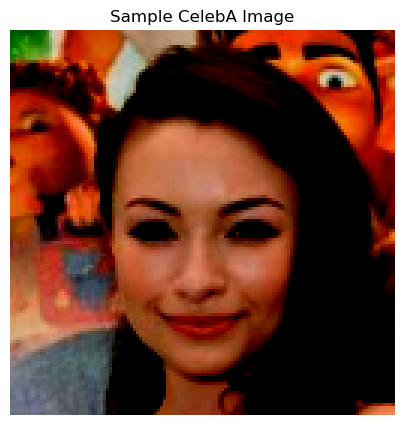

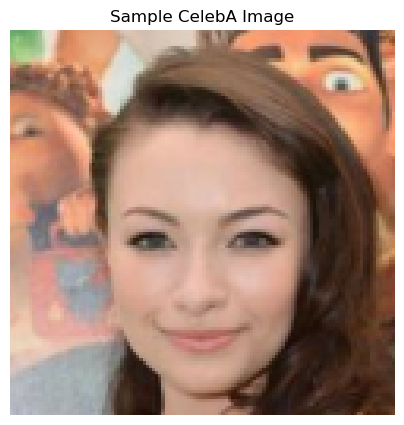

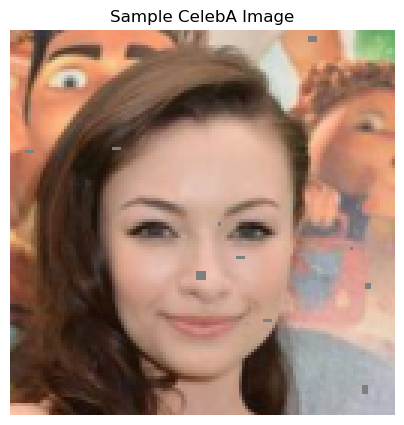

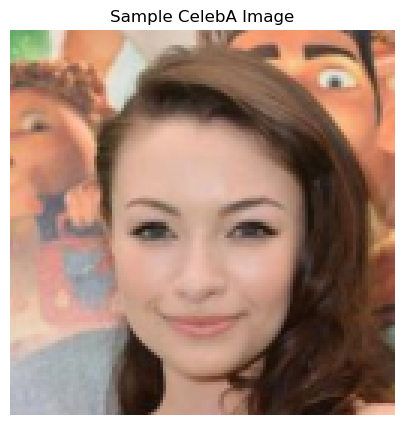

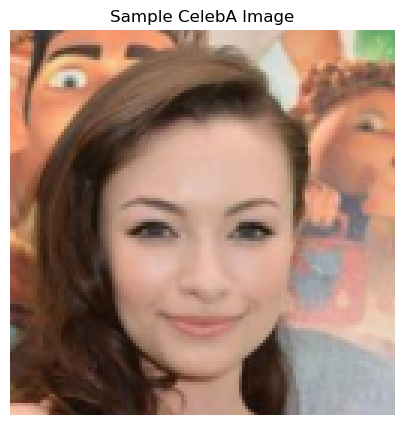

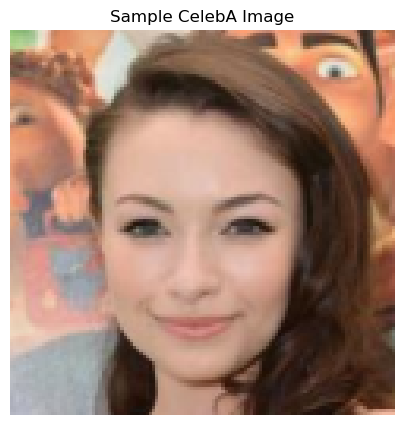

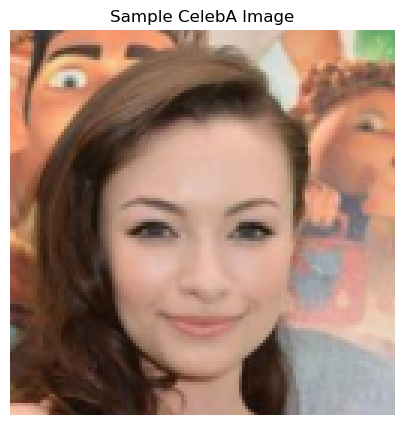

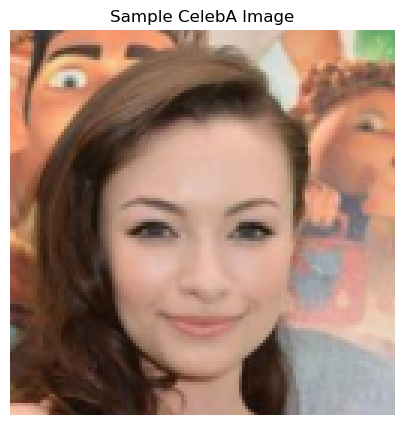

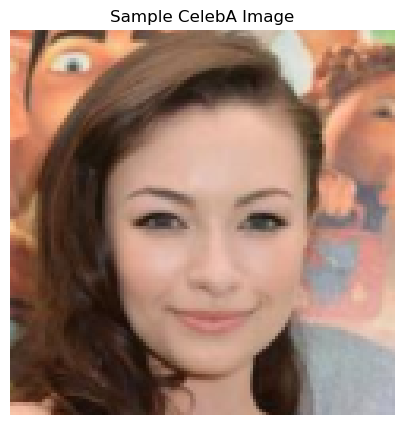

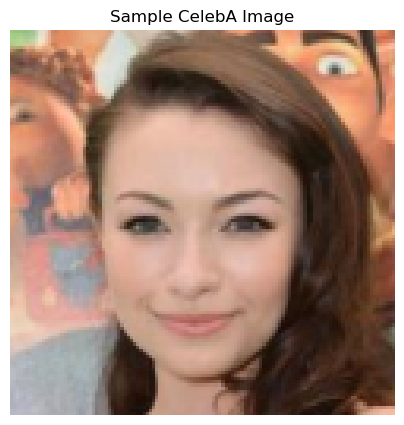

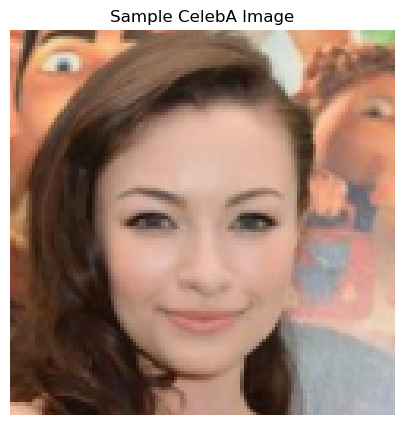

In [27]:
image, metas = celeba_data[sample_indices[3]]
image = torch.permute(image, (1, 2, 0))
transformed_image = image
print(transformed_image.shape)
viz_image(image)

for idx in range(10):
    # Apply transformations
    transform_pipeline = get_random_transforms()
    # print(transform_pipeline)

    # Apply transformations
    transform_pipeline = get_random_transforms()
    transformed = transform_pipeline(image=np.array(image))
    transformed_image = transformed["image"]
    # Convert to a PIL Image
    # print(transformed_image.min(), transformed_image.max())
    transformed_image = transformed_image * 0.5 + 0.5  # Undo normalization (if applied)
    # print(transformed_image.min(), transformed_image.max())
    transformed_image = (transformed_image.numpy() * 255).astype(np.uint8)
    if transformed_image.shape[0] == 3:
        transformed_image = np.transpose(transformed_image, (1, 2, 0))
    # print(f"Final transformed shape: ", transformed_image.shape)
    image_pil = Image.fromarray(
        transformed_image,
        # mode="RGB",
    )  # Assuming the tensor is in [0, 1] range

    # Print out the transformations in the pipeline
    # print_transforms(transform_pipeline, indent=0)

    viz_image(transformed_image)

    # save_path = Path("/Users/adam2392/Downloads/Pretrain-Gen")
    # save_path = save_path / f"{idx}.png"
    # image_pil.save(save_path)